In [1]:
import numpy as np
import arviz as az
import math
# import pymc3 as pm
import pickle
import matplotlib.pyplot as plt
from google.protobuf import text_format
from scipy.stats import multivariate_normal as mvn
from scipy.stats import skewnorm
from scipy.stats import norm
from scipy.interpolate import griddata
import pp_mix.protos.py.params_pb2 as params_pb2

from pp_mix.interface import ConditionalMCMC, cluster_estimate
from pp_mix.utils import loadChains, to_numpy, to_proto
from pp_mix.protos.py.state_pb2 import MultivariateMixtureState, EigenVector, EigenMatrix
from pp_mix.protos.py.params_pb2 import Params

# Generate data

assuming delta = I identical for all clusters

In [3]:
def generate_etas(mus, deltas_cov, cluster_alloc):
    np.random.seed(seed=233423)
    out = np.vstack([[mvn.rvs(mean = mus[i,:], cov = deltas_cov) for i in cluster_alloc]])
    return out

def generate_data(Lambda, etas, sigma_bar_cov):
    np.random.seed(seed=233423)
    means = np.matmul(Lambda,etas.T)
    sigma_bar_cov_mat = np.diag(sigma_bar_cov)
    out = np.vstack([[mvn.rvs(mean = means[:,i], cov = sigma_bar_cov_mat) for i in range(etas.shape[0])]])
    return out

def create_lambda(p,d):
    if p % d != 0:
        raise ValueError("Non compatible dimensions p and d: p={0}, d={1}".format(p,d))
    
    h = math.floor(p/d)
    Lambda=np.zeros((p,d))
    for i in range(d):
        Lambda[i*h:i*h+h,i] = np.ones(h)
        
    return Lambda

def create_mus(d,M,dist):
    mus = np.zeros((M,d))
    tot_range = (M-1)*dist 
    max_mu = tot_range/2
    for i in range(M):
        mus[i,:] = np.repeat(max_mu-i*dist, d)
        
    return mus

def create_cluster_alloc(n_pc,M):
    return np.repeat(range(M),n_pc)    

In [4]:
import csv
dist=5
p_s = [50, 100]
d_s = [2, 5]
M_s = [4]
n_percluster_s = [50, 200]

for p in p_s:
    sigma_bar_prec = np.repeat(2, p)
    sigma_bar_cov = 1/sigma_bar_prec
    for d in d_s:
        lamb = create_lambda(p,d)
        delta_cov = np.eye(d)
        for M in M_s:
            mus = create_mus(d,M,dist)
            for n_percluster in n_percluster_s:                
                cluster_alloc = create_cluster_alloc(n_percluster,M)
                etas = generate_etas(mus, delta_cov, cluster_alloc)
                data = generate_data(lamb, etas, sigma_bar_cov)
                #with open("data/data_script_sim/p_{0}_d_{1}_M_{2}_nperclus_{3}_data.csv".format(p,d,M,n_percluster),"w+") as my_csv:
                    csvWriter = csv.writer(my_csv, delimiter=',')
                    csvWriter.writerows(data)




In [2]:
import pandas as pd
with open("data/data_script_sim/p_50_d_2_M_4_nperclus_50_data.csv", newline='') as my_csv:
    data = pd.read_csv(my_csv, sep=',', header=None).values
    
print(data.shape)

(200, 50)


In [19]:
import itertools
import pandas as pd

p_s = [50] #p_s = [50, 100]
d_s = [2] #d_s = [2, 5]
M_s = [4]
n_percluster_s = [50, 200]

ntrick = 1000
nburn = 15000
niter = 15000
thin = 10

loops = [x for x in itertools.product(p_s,d_s,M_s,n_percluster_s)]

#for p, d, M, n_percluster in loops:
    print("Running p={0} d={1} M={2} nperclus={3}".format(p,d,M,n_percluster))
    with open("data/data_script_sim/p_{0}_d_{1}_M_{2}_nperclus_{3}_data.csv".format(p,d,M,n_percluster), newline='') as my_csv:
        data = pd.read_csv(my_csv, sep=',', header=None).values
    ranges = np.array([[-50,50],]*d).transpose()

    sampler = ConditionalMCMC(params_file = "data/data_script_sim/params/sampler_params_p_{0}_d_{1}_M_{2}_n_{3}.asciipb".format(p,d,M,n_percluster))
    sampler.run(ntrick, nburn, niter, thin, data, ranges, 200)
    sampler.serialize_chains("data/data_script_sim/chains/chains_p_{0}_d_{1}_M_{2}_nperclus_{3}.recordio".format(p,d,M,n_percluster))
    acc_rates = np.array([sampler.means_ar, sampler.lambda_ar])
    np.savetxt("data/data_script_sim/chains/acc_rate_p_{0}_d_{1}_M_{2}_nperclus_{3}.csv".format(p,d,M,n_percluster), acc_rates, delimiter=",")


Running p=50 d=2 M=4 nperclus=50
Trick, iter # 200  /  1000
Trick, iter # 400  /  1000
Trick, iter # 600  /  1000
Trick, iter # 800  /  1000
Trick, iter # 1000  /  1000
Burnin, iter # 200  /  15000
Burnin, iter # 400  /  15000
Burnin, iter # 600  /  15000
Burnin, iter # 800  /  15000
Burnin, iter # 1000  /  15000
Burnin, iter # 1200  /  15000
Burnin, iter # 1400  /  15000
Burnin, iter # 1600  /  15000
Burnin, iter # 1800  /  15000
Burnin, iter # 2000  /  15000
Burnin, iter # 2200  /  15000
Burnin, iter # 2400  /  15000
Burnin, iter # 2600  /  15000
Burnin, iter # 2800  /  15000
Burnin, iter # 3000  /  15000
Burnin, iter # 3200  /  15000
Burnin, iter # 3400  /  15000
Burnin, iter # 3600  /  15000
Burnin, iter # 3800  /  15000
Burnin, iter # 4000  /  15000
Burnin, iter # 4200  /  15000
Burnin, iter # 4400  /  15000
Burnin, iter # 4600  /  15000
Burnin, iter # 4800  /  15000
Burnin, iter # 5000  /  15000
Burnin, iter # 5200  /  15000
Burnin, iter # 5400  /  15000
Burnin, iter # 5600  /  1

Running, iter # 5400  /  15000
Running, iter # 5600  /  15000
Running, iter # 5800  /  15000
Running, iter # 6000  /  15000
Running, iter # 6200  /  15000
Running, iter # 6400  /  15000
Running, iter # 6600  /  15000
Running, iter # 6800  /  15000
Running, iter # 7000  /  15000
Running, iter # 7200  /  15000
Running, iter # 7400  /  15000
Running, iter # 7600  /  15000
Running, iter # 7800  /  15000
Running, iter # 8000  /  15000
Running, iter # 8200  /  15000
Running, iter # 8400  /  15000
Running, iter # 8600  /  15000
Running, iter # 8800  /  15000
Running, iter # 9000  /  15000
Running, iter # 9200  /  15000
Running, iter # 9400  /  15000
Running, iter # 9600  /  15000
Running, iter # 9800  /  15000
Running, iter # 10000  /  15000
Running, iter # 10200  /  15000
Running, iter # 10400  /  15000
Running, iter # 10600  /  15000
Running, iter # 10800  /  15000
Running, iter # 11000  /  15000
Running, iter # 11200  /  15000
Running, iter # 11400  /  15000
Running, iter # 11600  /  15000

In [3]:
chain0 = loadChains("data/data_script_sim/chains/chains_p_50_d_2_M_4_nperclus_50.recordio", MultivariateMixtureState)
#chain1 = loadChains("data/data_script_sim/chains/chains_p_50_d_5_M_4_nperclus_50.recordio", MultivariateMixtureState)
chain2 = loadChains("data/data_script_sim/chains/chains_p_50_d_2_M_4_nperclus_200.recordio", MultivariateMixtureState)
#chain3 = loadChains("data/data_script_sim/chains/chains_p_50_d_5_M_4_nperclus_200.recordio", MultivariateMixtureState)

In [4]:
nc_chain0 = np.array([x.ma for x in chain0])
nonall_0 = np.array([x.mna for x in chain0])
#nc_chain1 = np.array([x.ma for x in chain1])
nc_chain2 = np.array([x.ma for x in chain2])
nonall_2 = np.array([x.mna for x in chain2])

#nc_chain3 = np.array([x.ma for x in chain3])

print(nc_chain0.mean())
print(nonall_0.mean())

#print(nc_chain1.mean())
print(nc_chain2.mean())
print(nonall_2.mean())

#print(nc_chain3.mean())

4.0
0.4513333333333333
4.0
0.46


In [7]:
chain0[-1].clus_alloc

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

# evaluate performance on simulate data: return performance dataframe 

In [15]:
import itertools
from scipy import stats
from sklearn.metrics import adjusted_rand_score
import pandas as pd
from math import sqrt

p_s = [50] #p_s = [50, 100]
d_s = [2]
M_s = [4]
n_percluster_s = [50,200]
list_performance = list()


#for p, d, M, n_percluster in itertools.product(p_s,d_s,M_s,n_percluster_s):
    chain = loadChains("data/data_script_sim/chains/chains_p_{0}_d_{1}_M_{2}_nperclus_{3}.recordio".format(p,d,M,n_percluster), MultivariateMixtureState)
    acc_rates = np.loadtxt("data/data_script_sim/chains/acc_rate_p_{0}_d_{1}_M_{2}_nperclus_{3}.csv".format(p,d,M,n_percluster), delimiter=',')

    n_cluster_chain = np.array([x.ma for x in chain])
    post_mode_nclus = stats.mode(n_cluster_chain)[0][0] # store in dataframe
    post_avg_nclus = n_cluster_chain.mean() # store in dataframe
    
    clus_alloc_chain = [x.clus_alloc for x in chain]
    best_clus = cluster_estimate(np.array(clus_alloc_chain))
    true_clus = np.repeat(range(M),n_percluster)
    ari_best_clus = adjusted_rand_score(true_clus, best_clus) # store in dataframe
    
    aris_chain = np.array([adjusted_rand_score(true_clus, x) for x in clus_alloc_chain])
    mean_aris, sigma_aris = np.mean(aris_chain), np.std(aris_chain) # store mean_aris in dataframe
    CI_aris = stats.norm.interval(0.95, loc=mean_aris, scale=sigma_aris/sqrt(len(aris_chain))) # store in dataframe
    
    list_performance.append([p,d,M,n_percluster,acc_rates[0],acc_rates[1],post_mode_nclus,
                        post_avg_nclus,ari_best_clus,mean_aris,CI_aris])
    

    
df_performance = pd.DataFrame(list_performance, columns=('dim_p', 'dim_d', 'dim_M', 'dim_n_pc', 'means_ar','lambda_ar',
                                      'mode_nclus', 'avg_nclus', 'ari_best_clus', 'mean_ari', 'CI_ari'))
    


In [16]:
df_performance

,dim_p,dim_d,dim_M,dim_n_pc,means_ar,lambda_ar,mode_nclus,avg_nclus,ari_best_clus,mean_ari,CI_ari
0,50,2,4,50,0.777467,0.075097,4,4.0,1.0,0.999946,"(0.9999035896599989, 0.9999892013795285)"
1,50,2,4,200,0.179443,0.167742,4,4.0,1.0,0.998505,"(0.9984057512126745, 0.998605038987719)"


# check chain mixing on some variables 

In [18]:
import pymc3


In [26]:
tau_chain0 = np.array([x.lamb_block.tau for x in chain0])
tau_chain2 = np.array([x.lamb_block.tau for x in chain2])

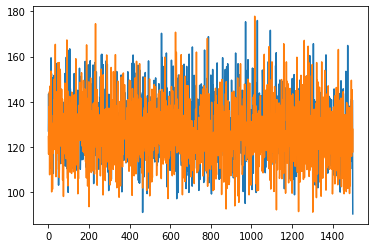

In [27]:
plt.plot(tau_chain0)
plt.plot(tau_chain2)

In [30]:
first_sigma_bar_chain0 = np.array([to_numpy(x.sigma_bar)[0] for x in chain0])
last_sigma_bar_chain0 = np.array([to_numpy(x.sigma_bar)[-1] for x in chain0])

first_sigma_bar_chain2 = np.array([to_numpy(x.sigma_bar)[0] for x in chain2])
last_sigma_bar_chain2 = np.array([to_numpy(x.sigma_bar)[-1] for x in chain2])


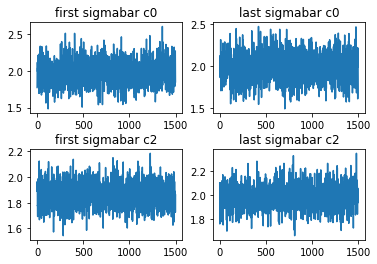

In [34]:
fig_sigma = plt.figure()
ax1 = fig_sigma.add_subplot(221)
ax1.plot(first_sigma_bar_chain0)
plt.title('first sigmabar c0')

ax2 = fig_sigma.add_subplot(222)
ax2.plot(last_sigma_bar_chain0)
plt.title('last sigmabar c0')

ax3 = fig_sigma.add_subplot(223)
ax3.plot(first_sigma_bar_chain2)
plt.title('first sigmabar c2')

ax4 = fig_sigma.add_subplot(224)
ax4.plot(last_sigma_bar_chain2)
plt.title('last sigmabar c2')

plt.subplots_adjust(hspace=0.4)
